# <center>Tarea 4<center>
# <center>Para entregar el 13 de noviembre<center>

## 1. En este ejercicio, implementarás un modelo de lenguaje a nivel de caracteres. Considera el siguiente código base para un texto en particular.

In [ ]:
import keras
import numpy as np
from keras import layers
from keras.models import Sequential

# en este ejemplo, se usa éste texto...
path = '/home/victor/cursos/optativa2020/data/nietzsche.txt'
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 600893


Definimos las secuencias, vocabulario y demás cosas para el modelo

In [ ]:
# Length of extracted character sequences
maxlen = 60
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


Ahora, considera éste modelo como el baseline

In [ ]:
model = Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               95232     
_________________________________________________________________
dense (Dense)                (None, 57)                7353      
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________


Lo siguiente es entrenar el modelo, dar una secuencia inicial y generar texto a partir de esto. 
Una modificación para tratar de evitar la repetitividad de las secuencias generadas (sobre todo en las primeras épocas del entrenamiento), es modificar la distribución de probabilidad `softmax` para introducir cierta aleatoriedad en el proceso de muestreo (stochastic sampling). A partir de cierto parámetro ("temperatura"), se construye una nueva distribución de probabilidad de las salidas del modelo. El siguiente código implementa ésta idea.

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

El modelo de lenguaje queda entonces como

In [ ]:
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.5, 1.0]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

### a) Adapta el modelo anterior y aplícalo al texto contenido en el archivo `@lopezobrador__tweets.csv`, que contiene el historial de tuits bajados de la cuenta oficial de Andres Manuel López Obrador. Realiza el preproceso que creas conveniente en el texto. Puedes modificar los parámetros del modelo, pero reporta todos los ajustes que hiciste. Realiza pruebas con distintos valores de temperatura y da tu opinión sobre la `calidad` del texto generado.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Respuesta:

- Para los tweets, se realizó un pre-proceso, se pusieron todos los caracteres en minúsculas, se quitaron acentos, se quitaron caracteres duplicados, se cambiaron los Urls por la palabra url al final del tweet, se quitaron posibles emojis o referencias a otros usuarios (@user).

- Para el modelo, se probó el baseline con 5 epocas, diferentes optmizadores (RMSprop, SGD, Adam), diferentes tamaños de learning rate (0.001, 0.01, 0.1), diferentes tamaños de minibatch (8-512). Posteriormente se probó con diferente numero de unidades en la capa LSTM (64-256), agregando mas capas LSTM y probando con capa bidireccionales y por ultimo dejando entrenar el modelo hasta obtener una buena generación de texto.

- El mejor modelo resultó entrenando por 40 epocas, con optimizador RMSprop, con learning rate 0.01, con tamaño de minibatch de 256, con capa LSTM con 256 unidades y una capa densa con el tamaño de numero de caracteres y función de activación softmax, con un error de entrenamiento de 0.71


In [2]:
# librerias
import tensorflow as tf
import random
import numpy as np

#path
path = "/content/drive/My Drive/Colab Notebooks/Tarea 4-20201105/Tarea4_victor_gomez/" #path de los archivos

#tweets
text = open(path+"Tarea4_victor_gomez_tweets.txt").read().lower() #carga los tweets procesados

#modelo
Modelo1 = tf.keras.models.load_model(path+'Tarea4_victor_gomez_P1.h5') #carga el mejor modelo
Modelo1.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 256)               319488    
_________________________________________________________________
dense_36 (Dense)             (None, 55)                14135     
Total params: 333,623
Trainable params: 333,623
Non-trainable params: 0
_________________________________________________________________


In [6]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#Función para generar un tweet de AMLO
def generate_AMLO_tweet(model=Modelo1, text=text, temperature=0.3):
  maxlen=60
  chars = sorted(list(set(text))) #vocabulario o caracteres unicos
  char_indices = dict((char, chars.index(char)) for char in chars) #crea un diccionario donde las llaves son los caracteres y los valores son los indices
# Select a text seed at random
  start_index = random.randint(0, len(text) - maxlen - 1) #selecciona del texto original aleatoriamente una secuencia del mismo tamaño con el que se entrenó
  generated_text = text[start_index: start_index + maxlen]
  
  # We generate 140 characters
  i=0
  next_char=''
  tweet_char=[]
  tweet_char.append(generated_text)
  while i<140 and next_char != '\n': #genera 400 caracteres
    sampled = np.zeros((1, maxlen, len(chars))) #la semilla la vectoriza
    for t, char in enumerate(generated_text):
      sampled[0, t, char_indices[char]] = 1.

    preds = model.predict(sampled, verbose=0)[0] #predice con la semilla y obtiene la distribucion de probabilidad
    next_index = sample(preds, temperature) #obtiene el siguiente indice del caracter
    next_char = chars[next_index] #obtiene el caracter
    i+=1
    tweet_char.append(next_char)
    generated_text += next_char #concatena el caracter
    generated_text = generated_text[1:] #da un paso adelante para actualizar la entrada para la proxima prediccion
  tweet="".join(ch for ch in tweet_char)  #concatena
  print(tweet) #muestra el tweet

Finalmente se probó con diferentes valores de temperatura (0.2-3), notando que:

- Temperatura <0.3 se repetían mucho algunas palabras
- 0.3< Temperatura <0.5 se obtenían mejores tweets
- 0.5< Temperatura <1 se obtenían algunas palabras raras
- 1< Temperatura,  no tenía ningún sentido

Algunos ejemplos con temperatura=0.3:

In [8]:
print('AMLO Tweets:')
print()
for i in range(10):
  generate_AMLO_tweet()
  print()

AMLO Tweets:

 el acto en el d f enterate del plan de desobediencia civil para el bienestar de las refinerias de chihuahua y la lucha conferencia matutina url


mos ademas de las habitaciones el aula de formacion la cancha hacer en el problema de la gran para el programa de mexico url


ecion la perseverancia hay actividades y distractores pero no ros por la gente en la construcion de la construcion de la campana profundo en el mundo al amor y el consejo nacional de la convicion por 

 que pondra sobre la mesa epn frente a donald trump y se informe del prd url



 estamos en la inauguracion del foro escucha' en ciudad juarez el gobernador de la construcion de la camara de diputados de morena en el estado de mexico url


 y como pueden ver la gente sigue apoyandonos con convicion con la gente en el pais esta al pueblo de mexico url


ia matutina url
 es tiempo de plantear nuevas formas de convenicion a la mayoria de la frontera por la gente en el problema de corupcion de mexico url


er

In [ ]:
generate_AMLO_tweet()

e unidad por la prosperidad del pueblo y el renacimiento de mexico url



In [ ]:
generate_AMLO_tweet()

de 7 dias por veracruz url
 asi como en xoxocotla estuvieron en esta dialoga por la politica es un dia de reconstrucion a la mafia no atendera en el problema para el proyecto de nacion url



## 2. Considera un corpus de obras (cortas) de piano en formato `MIDI` como las que se encuentran en la carpeta `midi_train`.

## a) Crea música usando redes recurrentes. Puedes apoyarte en el código que pongo a continuación (detalles en clase).

In [ ]:
import pickle
import numpy
import os
from music21 import converter, instrument, note, chord, stream
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint

#os.chdir('/home/victor/cursos/optativa2020/')
# el directorio con el corpus de entrenamiento
midi_songs = 'data/midis/classic_piano/midi_train'

Pongo en la página unos MIDIs de entrenamiento, pero lo que recomiendo es que cada quien forme su corpus de entrenamiento. Yo obtuve los midi de http://www.piano-midi.de/midicoll.htm pero también puedes buscar otra fuente.

La parte que sigue puede usarse para el proceso de entrenamiento

In [ ]:
def get_notes():
    """ Obtiene las notas y acordes de los archivos midi que se encuentran en el directorio /midi_songs """
    notes = []

    for file in os.scandir(midi_songs):
        midi = converter.parse(file.path)

        print("Analizando %s" % file.name)

        notes_to_parse = None

        # en esta parte, se extraen todas las notas del archivo midi
        # como 'midi' es un objeto Score (que a su vez hereda de un Stream),
        # pueden accederse a todas las partes de la partitura (Score)
        
        # se consideran los casos en que el archivo midi tenga partes que correspondan a diferentes instrumentos
        # (solo se usa el primero, aunque puedan haber mas de 1), o que tenga solo las notas
        midi_parts = instrument.partitionByInstrument(midi)
        if midi_parts: 
            notes_to_parse = midi_parts.parts[0].recurse() 
        else: # notas en estructura flat
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    # guarda las notas. Este paso es muy importante, ya que se usaran en la fase de test,
    # es decir, cuando se generan notas a partir del modelo entrenado
    with open('programs/notebooks/data_mid/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes


def prepare_sequences(notes, n_vocab, sequence_length):
    """ Prepara las secuencias a usar en el modelo """

    # nuestro 'vocabulario' consiste en todas las notas unicas de los archivos midi
    pitchnames = sorted(set(item for item in notes))

     # se crea un diccionario para mapear notas a enteros
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # crea las secuencias de entrada y las salidas
    # podria usarse para una arquitectura 'many to one', pero también puedes
    # hacer un stack de RNNs (many to many)
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # redimensiona las secuencias de entrada para la RNN a usar
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normaliza
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)


In [ ]:
notes = get_notes()

In [ ]:
# puedes probar con varios longitudes de secuencias...
sequence = 50
# cantidad de notas
n_vocab = len(set(notes))
print('vocabulario:', n_vocab)

In [ ]:
network_input, network_output = prepare_sequences(notes, n_vocab, sequence)

No pongo el código del modelo que usé, pero en mi caso, usé la siguiente arquitectura. Puedes probar con ésa misma o alguna otra que tú sugieras.

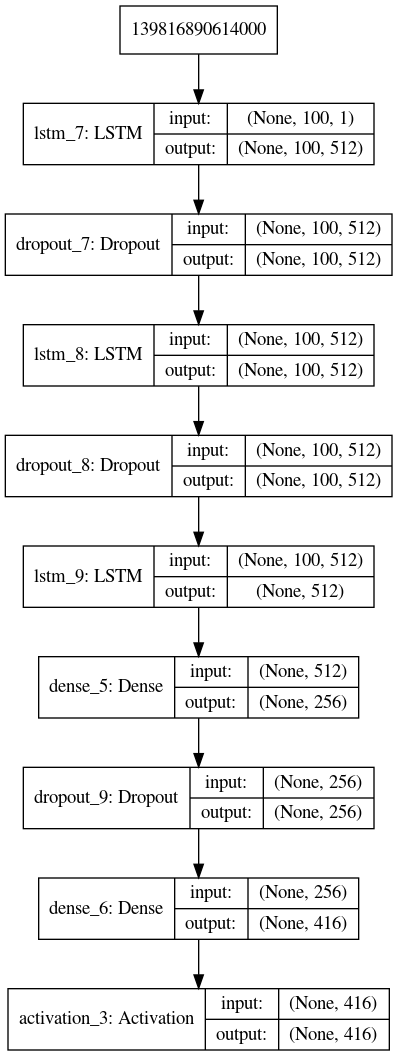

In [ ]:
Image(retina=True, filename='/home/victor/cursos/figs/midi_LSTM.png')

Ya que tienes el modelo entrenado y guardado, puedes generar una secuencia y guardarlo en archivo MIDI con el siguiente código

In [ ]:
def prepare_sequences_test(notes, pitchnames, n_vocab):
    """ Prepara las secuencias para usar en el modelo entrenado """
    
    # aqui, se realiza un mapeo (con diccionario) entre las notas y valores enteros y al reves
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # como antes, redimensionamos las entradas para poder usarse con LSTM
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalizamos la entrada
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

def generate_notes_test(model, network_input, pitchnames, n_vocab):
    """ Genera notas musicales a partir de una red neuronal basado en una secuencia inicial de notas """
    
    # selecciona una secuencia aleatoria del input a partir de la cual se realizaran predicciones
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # genera 500 notas (puedes cambiarlo)
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output, midfile):
    """ genera un archivo MIDI a partir de las notas generadas (o predichas) """
    offset = 0
    output_notes = []

    # crea los objetos fundamentales Note y Chrod basado en los valores genrados por el modelo entrenado
    for pattern in prediction_output:
        # si las notas forman un acorde...
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # si son notas...
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # incremental el offset en cada iteracion. El offset es la posicion dentro del stream de musica
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp = midfile)


Suponiendo que ya creaste un modelo (my_model), lo entrenaste y LO GUARDASTE, el siguiente código genera la música a partir de ese modelo

In [ ]:
""" Genera las notas y el archivo MIDI (piano) """

# carga las notas usadas cuando se entreno el modelo
with open('programs/notebooks/data_mid/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab)

# carga el modelo entrenado
from keras.models import load_model
model = load_model('programs/notebooks/my_model.hdf5')
# genera las notas
prediction_output = generate_notes_test(model, network_input, pitchnames, n_vocab)
# crea el MIDI
create_midi(prediction_output, 'programs/notebooks/test_output.mid')

SUGERENCIAS: 
- Guarda tu modelo en formato hdf5. Puedes guardar todo o parte, por ejemplo, solo los pesos, pero tendrás que re-definir la arquitectura en la fase de test.
- Usa callbacks y model check points para guardar tu modelo en cada época. Puede tardar mucho tiempo para entrenarse...

# Respuesta:

In [ ]:
# TU CÓDIGO AQUI

# librerias
import tensorflow as tf
import random
import numpy as np
import pickle
from music21 import converter, instrument, note, chord, stream

#path
path = "/content/drive/My Drive/Colab Notebooks/Tarea 4-20201105/Tarea4_victor_gomez/" #path de los archivos

#notas
with open(path+"Tarea4_victor_gomez_notes", 'rb') as filepath:
    notes = pickle.load(filepath)

#modelo
model = tf.keras.models.load_model(path+'Tarea4_victor_gomez_P2.hdf5') #carga el mejor modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 128)           66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 317)               40893     
Total params: 255,549
Trainable params: 255,549
Non-trainable params: 0
________________________________________________

- Para el modelo se utilizó una arquitectura con dos capas LSTM con 128 unidades, se utilizó una secuencia de tamaño de 50, las capas dropout con una tasa del 20%, al final dos capas densas una con 128 unidades y funcion de activacion relu al final una softmax con 317 unidades.

- el modelo se dejó entrenar durante 50 épocas con un learning rate de 0.01 con el optimizador Adamax con tamaño de minibatch de 50 llegando a un error de entrenamiento de 2.06

- el corpus de entrenamiento utilizado fue unicamente con los midi de chopin

- Se observó que de no incluir nuevamente la función sample y cambiando el valor de temperatura a 0.3-0.4, la función argmax lo que hace es que tiende a repetir la misma nota, o en el caso de texto la misma palabra o frase.

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def prepare_sequences_test(notes, pitchnames, n_vocab):
    """ Prepara las secuencias para usar en el modelo entrenado """
    
    # aqui, se realiza un mapeo (con diccionario) entre las notas y valores enteros y al reves
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 50
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # como antes, redimensionamos las entradas para poder usarse con LSTM
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalizamos la entrada
    normalized_input = normalized_input / float(n_vocab)
    
    return (network_input, normalized_input)

def generate_notes_test(model, network_input, pitchnames, n_vocab):
    """ Genera notas musicales a partir de una red neuronal basado en una secuencia inicial de notas """
    
    # selecciona una secuencia aleatoria del input a partir de la cual se realizaran predicciones
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []
    temperature=0.3
    # genera 500 notas (puedes cambiarlo)
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)[0]

        index = sample(prediction, temperature) #obtiene el siguiente indice las notas
        #index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output, midfile):
    """ genera un archivo MIDI a partir de las notas generadas (o predichas) """
    offset = 0
    output_notes = []

    # crea los objetos fundamentales Note y Chrod basado en los valores genrados por el modelo entrenado
    for pattern in prediction_output:
        # si las notas forman un acorde...
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # si son notas...
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # incremental el offset en cada iteracion. El offset es la posicion dentro del stream de musica
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp = midfile)

""" Genera las notas y el archivo MIDI (piano) """

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab)

# genera las notas
prediction_output = generate_notes_test(model, network_input, pitchnames, n_vocab)
# crea el MIDI
create_midi(prediction_output, path+'/Tarea4_victor_gomez_midi.mid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


## b) La generación de música que hicimos es muy básica y tiene varias limitaciones (¡pero aún así es sorprendente!). Una de ellas es que las notas generadas tienen solo una duración. Otra es que solo usan un instrumento. ¿Qué ideas se te ocurren para extender el método en ambos casos, que puedan implementarse en términos de redes recurrentes o Deep Learning en general?

## Quizá la lectura de Briot et al. (2019, 2017) y Huang & Wu (2016) puedan ayudar.

- Se me ocurre que haciendo una analogía con los modelos para textos, se pueda hacer como un embedding de instrumentos, y de esta forma encontrar por ejemplo cuales estén relacionados musicalmente (honestamente no sé mucho de música y no me interesa el tema), de forma similar a como en textos se pueden utilizar para encontrar el contexto entre palabras, podríamos encontrar patrones de como se relaciona la guitarra con el bajo o batería y formar secuencias musicales mas complejas.    

- Creo que para poder comprender un poco mejor el tema y las correspondientes lecturas, se necesita un poco más de contexto (e interés) en el tema de la música, en lo personal no me fue sencillo comprender las ideas al respecto.